In [ ]:
# Small-data turn-on/off for all 6 notebook runs (01→06). Set once; applies to full pipeline.
USE_SMALL_DATA = False  # True = small data (N_SAMPLES); False = full data
N_SAMPLES = 10       # Max observations when USE_SMALL_DATA (e.g. 10 for quick test)
N_EPOCHS = 1       # Max training epochs when USE_SMALL_DATA (02, 03, 04)
# 01: applied automatically below. 02-04: epochs/n_epochs/num_epochs set automatically.

In [ ]:
# Imports and setup (needed when 02-06 run in separate kernel)
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Repo root for src imports
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass
def _find_repo_root():
    cwd = Path.cwd().resolve()
    for p in [Path('/content/drive/MyDrive/multihead-attention-robustness'),
              Path('/content/drive/My Drive/multihead-attention-robustness'),
              Path('/content/repo_run')]:
        if (p / 'src').exists():
            return p
    drive_root = Path('/content/drive')
    if drive_root.exists():
        for base in [drive_root / 'MyDrive', drive_root / 'My Drive', drive_root]:
            p = base / 'multihead-attention-robustness'
            if p.exists() and (p / 'src').exists():
                return p
    p = cwd
    for _ in range(10):
        if (p / 'src').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return cwd.parent if cwd.name == 'notebooks' else cwd
repo_root = _find_repo_root()
sys.path.insert(0, str(repo_root))
from src.models.feature_token_transformer import FeatureTokenTransformer, SingleHeadTransformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
models = {}
training_history = {}
TRAINING_CONFIG = {
    'ols': {}, 'ridge': {'alpha': 1.0},
    'mlp': {'hidden_dims': [128, 64], 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'patience': 10},
    'transformer': {'d_model': 72, 'num_heads': 8, 'num_layers': 2, 'd_ff': 512, 'dropout': 0.1,
                   'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 100, 'patience': 20}
}


In [ ]:
# Load fresh data from master_table.csv (standalone: each notebook pulls its own data)
data_path = repo_root / 'data' / 'cross_sectional' / 'master_table.csv'
df = pd.read_csv(data_path)
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
class CrossSectionalDataSplitter:
    def __init__(self, train_start='2005-01-01', train_end='2017-12-31', val_start='2018-01-01', val_end='2019-12-31'):
        self.train_start, self.train_end = train_start, train_end
        self.val_start, self.val_end = val_start, val_end
    def split(self, master_table):
        master_table = master_table.copy()
        master_table.index = pd.to_datetime(master_table.index)
        return {'train': master_table.loc[self.train_start:self.train_end], 'val': master_table.loc[self.val_start:self.val_end]}
    def prepare_features_labels(self, data):
        if data.empty:
            return pd.DataFrame(), pd.Series()
        numeric_data = data.select_dtypes(include=[np.number])
        if numeric_data.empty:
            return pd.DataFrame(), pd.Series()
        exclude_cols = ['mktcap', 'market_cap', 'date', 'year', 'month', 'ticker', 'permno', 'gvkey']
        target_cols = ['return', 'returns', 'ret', 'target', 'y', 'next_return', 'forward_return', 'ret_1', 'ret_1m', 'ret_12m', 'future_return', 'returns_1d']
        target_col = None
        for tc in target_cols:
            for col in numeric_data.columns:
                if tc.lower() in col.lower() and col.lower() not in [ec.lower() for ec in exclude_cols]:
                    target_col = col
                    break
            if target_col:
                break
        if target_col is None:
            potential = [c for c in numeric_data.columns if c.lower() not in [ec.lower() for ec in exclude_cols]]
            target_col = potential[-2] if len(potential) > 1 else (potential[-1] if potential else numeric_data.columns[-1])
        feature_cols = [c for c in numeric_data.columns if c != target_col and c.lower() not in [ec.lower() for ec in exclude_cols]]
        if not feature_cols:
            feature_cols = [c for c in numeric_data.columns if c != target_col]
        if not feature_cols:
            feature_cols = numeric_data.columns[:-1].tolist()
            target_col = numeric_data.columns[-1]
        return numeric_data[feature_cols], numeric_data[target_col]
splitter = CrossSectionalDataSplitter()
data_splits = splitter.split(df)
train_df, val_df = data_splits['train'], data_splits['val']
X_train_df, y_train = splitter.prepare_features_labels(train_df)
X_val_df, y_val = splitter.prepare_features_labels(val_df)
X_train = X_train_df.fillna(0).values.astype(np.float32)
y_train = y_train.fillna(0).values.astype(np.float32)
X_val = X_val_df.fillna(0).values.astype(np.float32)
y_val = y_val.fillna(0).values.astype(np.float32)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print(f'Loaded fresh data: train {X_train_scaled.shape[0]}, val {X_val_scaled.shape[0]}')


In [ ]:
epochs = n_epochs = num_epochs = 100  # full training (standalone mode)


In [4]:
# Training configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Store trained models
models = {}
training_history = {}

# Training hyperparameters
TRAINING_CONFIG = {
    'ols': {},
    'ridge': {'alpha': 1.0},
    'mlp': {
        'hidden_dims': [128, 64],
        'learning_rate': 0.001,
        'batch_size': 64,
        'epochs': 100,
        'patience': 10
    },
    'transformer': {
        'd_model': 72,
        'num_heads': 8,  
        'num_layers': 2,
        'd_ff': 512,
        'dropout': 0.1,
        'learning_rate': 0.0001,
        'batch_size': 32,
        'epochs': 100,
        'patience': 20
    }
}

Using device: cuda


In [6]:
# Train OLS (Linear Regression)
from sklearn.linear_model import LinearRegression

print("=" * 80)
print("TRAINING OLS MODEL")
print("=" * 80)

ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

models['OLS'] = ols_model

# Evaluate on validation set
ols_pred = ols_model.predict(X_val_scaled)
ols_rmse = np.sqrt(mean_squared_error(y_val, ols_pred))
ols_r2 = r2_score(y_val, ols_pred)

print(f"✓ OLS trained")
print(f"  Validation RMSE: {ols_rmse:.6f}")
print(f"  Validation R²: {ols_r2:.6f}")

training_history['OLS'] = {'rmse': ols_rmse, 'r2': ols_r2}

TRAINING OLS MODEL


✓ OLS trained
  Validation RMSE: 0.017520
  Validation R²: -0.007658


In [ ]:
# Train XGBoost
try:
    import xgboost as xgb
except ImportError:
    print("XGBoost not installed. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb

print("=" * 80)
print("TRAINING XGBOOST MODEL")
print("=" * 80)

# XGBoost configuration
xgboost_config = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_SEED,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Train XGBoost model
xgboost_model = xgb.XGBRegressor(**xgboost_config)
xgboost_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

models['XGBoost'] = xgboost_model

# Evaluate on validation set
xgboost_pred = xgboost_model.predict(X_val_scaled)
xgboost_rmse = np.sqrt(mean_squared_error(y_val, xgboost_pred))
xgboost_r2 = r2_score(y_val, xgboost_pred)

print(f"✓ XGBoost trained")
print(f"  Validation RMSE: {xgboost_rmse:.6f}")
print(f"  Validation R²: {xgboost_r2:.6f}")

training_history['XGBoost'] = {'rmse': xgboost_rmse, 'r2': xgboost_r2}

In [7]:
# Train Ridge Regression
from sklearn.linear_model import Ridge

print("=" * 80)
print("TRAINING RIDGE MODEL")
print("=" * 80)

ridge_model = Ridge(alpha=TRAINING_CONFIG['ridge']['alpha'], random_state=RANDOM_SEED)
ridge_model.fit(X_train_scaled, y_train)

models['Ridge'] = ridge_model

# Evaluate on validation set
ridge_pred = ridge_model.predict(X_val_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_val, ridge_pred))
ridge_r2 = r2_score(y_val, ridge_pred)

print(f"✓ Ridge trained")
print(f"  Validation RMSE: {ridge_rmse:.6f}")
print(f"  Validation R²: {ridge_r2:.6f}")

training_history['Ridge'] = {'rmse': ridge_rmse, 'r2': ridge_r2}

TRAINING RIDGE MODEL
✓ Ridge trained
  Validation RMSE: 0.017519
  Validation R²: -0.007585


In [8]:
# Train MLP (Multi-Layer Perceptron)
print("=" * 80)
print("TRAINING MLP MODEL")
print("=" * 80)

class MLP(nn.Module):
    """Simple MLP for regression."""
    def __init__(self, input_dim, hidden_dims, dropout=0.1):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze(-1)

mlp_config = TRAINING_CONFIG['mlp']
mlp_model = MLP(
    input_dim=X_train_scaled.shape[1],
    hidden_dims=mlp_config['hidden_dims'],
    dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=mlp_config['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

for epoch in range(mlp_config['epochs']):
    # Training
    mlp_model.train()
    optimizer.zero_grad()
    train_pred = mlp_model(X_train_tensor)
    train_loss = criterion(train_pred, y_train_tensor)
    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(mlp_model.parameters(), max_norm=1.0)
    optimizer.step()
    
    # Validation
    mlp_model.eval()
    with torch.no_grad():
        val_pred = mlp_model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= mlp_config['patience']:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{mlp_config['epochs']}: Train Loss={train_loss.item():.6f}, Val Loss={val_loss.item():.6f}")

mlp_model.eval()
with torch.no_grad():
    mlp_pred = mlp_model(X_val_tensor).cpu().numpy()

mlp_rmse = np.sqrt(mean_squared_error(y_val, mlp_pred))
mlp_r2 = r2_score(y_val, mlp_pred)

models['MLP'] = mlp_model
print(f"✓ MLP trained")
print(f"  Validation RMSE: {mlp_rmse:.6f}")
print(f"  Validation R²: {mlp_r2:.6f}")

training_history['MLP'] = {'rmse': mlp_rmse, 'r2': mlp_r2, 'train_losses': train_losses, 'val_losses': val_losses}

TRAINING MLP MODEL


  Epoch 10/100: Train Loss=0.003197, Val Loss=0.001564
  Epoch 20/100: Train Loss=0.002130, Val Loss=0.000643
  Epoch 30/100: Train Loss=0.001545, Val Loss=0.000564
  Epoch 40/100: Train Loss=0.001303, Val Loss=0.000502
  Epoch 50/100: Train Loss=0.001119, Val Loss=0.000452
  Epoch 60/100: Train Loss=0.001040, Val Loss=0.000423
  Epoch 70/100: Train Loss=0.000988, Val Loss=0.000411
  Epoch 80/100: Train Loss=0.000964, Val Loss=0.000405
  Epoch 90/100: Train Loss=0.000936, Val Loss=0.000397
  Epoch 100/100: Train Loss=0.000924, Val Loss=0.000394
✓ MLP trained
  Validation RMSE: 0.019840
  Validation R²: -0.292290


In [9]:
# Train Transformer Models
print("=" * 80)
print("TRAINING TRANSFORMER MODELS")
print("=" * 80)

def train_transformer(model, model_name, X_train, y_train, X_val, y_val, config, device='cpu'):
    """Train a transformer model."""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Handle feature dimension mismatch
    num_features = model.num_features if hasattr(model, 'num_features') else model.model.num_features
    
    if X_train.shape[1] != num_features:
        if X_train.shape[1] < num_features:
            # Pad
            padding_train = np.zeros((X_train.shape[0], num_features - X_train.shape[1]))
            padding_val = np.zeros((X_val.shape[0], num_features - X_val.shape[1]))
            X_train_tensor = torch.FloatTensor(np.hstack([X_train, padding_train])).to(device)
            X_val_tensor = torch.FloatTensor(np.hstack([X_val, padding_val])).to(device)
        else:
            # Truncate
            X_train_tensor = torch.FloatTensor(X_train[:, :num_features]).to(device)
            X_val_tensor = torch.FloatTensor(X_val[:, :num_features]).to(device)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    batch_size = config['batch_size']
    n_batches = (len(X_train_tensor) + batch_size - 1) // batch_size
    
    for epoch in range(config['epochs']):
        # Training
        model.train()
        epoch_train_loss = 0.0
        
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            
            optimizer.zero_grad()
            pred = model(batch_X)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = criterion(pred.squeeze(), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        epoch_train_loss /= n_batches
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            if isinstance(val_pred, tuple):
                val_pred = val_pred[0]
            val_loss = criterion(val_pred.squeeze(), y_val_tensor)
        
        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss.item())
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                print(f"  {model_name}: Early stopping at epoch {epoch+1}")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"  {model_name} - Epoch {epoch+1}/{config['epochs']}: Train Loss={epoch_train_loss:.6f}, Val Loss={val_loss.item():.6f}")
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        final_pred = model(X_val_tensor)
        if isinstance(final_pred, tuple):
            final_pred = final_pred[0]
        final_pred = final_pred.squeeze().cpu().numpy()
    
    return model, final_pred, train_losses, val_losses

# Train Single-Head Transformer
print("\nTraining Single-Head Transformer...")
single_head_model = SingleHeadTransformer(
    num_features=X_train_scaled.shape[1],
    d_model=TRAINING_CONFIG['transformer']['d_model'],
    num_layers=TRAINING_CONFIG['transformer']['num_layers']
)
single_head_model, single_head_pred, sh_train_losses, sh_val_losses = train_transformer(
    single_head_model, 'Single-Head', X_train_scaled, y_train, X_val_scaled, y_val,
    TRAINING_CONFIG['transformer'], device
)

single_head_rmse = np.sqrt(mean_squared_error(y_val, single_head_pred))
single_head_r2 = r2_score(y_val, single_head_pred)

models['Single-Head'] = single_head_model
print(f"Single-Head trained - RMSE: {single_head_rmse:.6f}, R²: {single_head_r2:.6f}")
training_history['Single-Head'] = {'rmse': single_head_rmse, 'r2': single_head_r2, 'train_losses': sh_train_losses, 'val_losses': sh_val_losses}

TRAINING TRANSFORMER MODELS

Training Single-Head Transformer...


  Single-Head - Epoch 10/100: Train Loss=0.000589, Val Loss=0.000290


  Single-Head - Epoch 20/100: Train Loss=0.000513, Val Loss=0.000291


  Single-Head - Epoch 30/100: Train Loss=0.000480, Val Loss=0.000284


  Single-Head - Epoch 40/100: Train Loss=0.000474, Val Loss=0.000282


  Single-Head - Epoch 50/100: Train Loss=0.000454, Val Loss=0.000278


  Single-Head - Epoch 60/100: Train Loss=0.000442, Val Loss=0.000276


  Single-Head - Epoch 70/100: Train Loss=0.000430, Val Loss=0.000274


  Single-Head - Epoch 80/100: Train Loss=0.000425, Val Loss=0.000274


  Single-Head - Epoch 90/100: Train Loss=0.000421, Val Loss=0.000274


  Single-Head: Early stopping at epoch 95
Single-Head trained - RMSE: 0.016555, R²: 0.100279


In [10]:
%%time
# Train Multi-Head Transformer
print("\nTraining Multi-Head Transformer...")
multi_head_model = FeatureTokenTransformer(
    num_features=X_train_scaled.shape[1],
    d_model=TRAINING_CONFIG['transformer']['d_model'],
    num_heads=TRAINING_CONFIG['transformer']['num_heads'],
    num_layers=TRAINING_CONFIG['transformer']['num_layers'],
    d_ff=TRAINING_CONFIG['transformer']['d_ff'],
    dropout=TRAINING_CONFIG['transformer']['dropout'],
    use_head_diversity=False
)
multi_head_model, multi_head_pred, mh_train_losses, mh_val_losses = train_transformer(
    multi_head_model, 'Multi-Head', X_train_scaled, y_train, X_val_scaled, y_val,
    TRAINING_CONFIG['transformer'], device
)

multi_head_rmse = np.sqrt(mean_squared_error(y_val, multi_head_pred))
multi_head_r2 = r2_score(y_val, multi_head_pred)

models['Multi-Head'] = multi_head_model
print(f"✓ Multi-Head trained - RMSE: {multi_head_rmse:.6f}, R²: {multi_head_r2:.6f}")
training_history['Multi-Head'] = {'rmse': multi_head_rmse, 'r2': multi_head_r2, 'train_losses': mh_train_losses, 'val_losses': mh_val_losses}


Training Multi-Head Transformer...


  Multi-Head - Epoch 10/100: Train Loss=0.000616, Val Loss=0.000298


  Multi-Head - Epoch 20/100: Train Loss=0.000545, Val Loss=0.000303


  Multi-Head - Epoch 30/100: Train Loss=0.000511, Val Loss=0.000292


  Multi-Head - Epoch 40/100: Train Loss=0.000492, Val Loss=0.000286


  Multi-Head - Epoch 50/100: Train Loss=0.000473, Val Loss=0.000282


  Multi-Head - Epoch 60/100: Train Loss=0.000456, Val Loss=0.000280


  Multi-Head - Epoch 70/100: Train Loss=0.000438, Val Loss=0.000273


  Multi-Head - Epoch 80/100: Train Loss=0.000427, Val Loss=0.000271


  Multi-Head - Epoch 90/100: Train Loss=0.000420, Val Loss=0.000270


  Multi-Head - Epoch 100/100: Train Loss=0.000416, Val Loss=0.000269
✓ Multi-Head trained - RMSE: 0.016388, R²: 0.118330
CPU times: user 4min 10s, sys: 1.35 s, total: 4min 11s
Wall time: 4min 13s


In [11]:
# Train Multi-Head Diversity Transformer
print("\nTraining Multi-Head Diversity Transformer...")
multi_head_diversity_model = FeatureTokenTransformer(
    num_features=X_train_scaled.shape[1],
    d_model=TRAINING_CONFIG['transformer']['d_model'],
    num_heads=TRAINING_CONFIG['transformer']['num_heads'],
    num_layers=TRAINING_CONFIG['transformer']['num_layers'],
    d_ff=TRAINING_CONFIG['transformer']['d_ff'],
    dropout=TRAINING_CONFIG['transformer']['dropout'],
    use_head_diversity=True,
    diversity_weight=0.01
)
multi_head_diversity_model, mhd_pred, mhd_train_losses, mhd_val_losses = train_transformer(
    multi_head_diversity_model, 'Multi-Head Diversity', X_train_scaled, y_train, X_val_scaled, y_val,
    TRAINING_CONFIG['transformer'], device
)

multi_head_diversity_rmse = np.sqrt(mean_squared_error(y_val, mhd_pred))
multi_head_diversity_r2 = r2_score(y_val, mhd_pred)

models['Multi-Head Diversity'] = multi_head_diversity_model
print(f"✓ Multi-Head Diversity trained - RMSE: {multi_head_diversity_rmse:.6f}, R²: {multi_head_diversity_r2:.6f}")
training_history['Multi-Head Diversity'] = {'rmse': multi_head_diversity_rmse, 'r2': multi_head_diversity_r2, 'train_losses': mhd_train_losses, 'val_losses': mhd_val_losses}

print("\n" + "=" * 80)
print("ALL MODELS TRAINED")
print("=" * 80)
print(f"Total models trained: {len(models)}")
print("\nValidation Results Summary:")
for name, metrics in training_history.items():
    print(f"  {name}: RMSE={metrics['rmse']:.6f}, R²={metrics['r2']:.6f}")


Training Multi-Head Diversity Transformer...


  Multi-Head Diversity - Epoch 10/100: Train Loss=0.000615, Val Loss=0.000313


  Multi-Head Diversity - Epoch 20/100: Train Loss=0.000549, Val Loss=0.000302


  Multi-Head Diversity - Epoch 30/100: Train Loss=0.000522, Val Loss=0.000291


  Multi-Head Diversity - Epoch 40/100: Train Loss=0.000495, Val Loss=0.000283


  Multi-Head Diversity - Epoch 50/100: Train Loss=0.000478, Val Loss=0.000279


  Multi-Head Diversity - Epoch 60/100: Train Loss=0.000460, Val Loss=0.000276


  Multi-Head Diversity - Epoch 70/100: Train Loss=0.000448, Val Loss=0.000275


  Multi-Head Diversity - Epoch 80/100: Train Loss=0.000435, Val Loss=0.000276


  Multi-Head Diversity - Epoch 90/100: Train Loss=0.000422, Val Loss=0.000274


  Multi-Head Diversity: Early stopping at epoch 92
✓ Multi-Head Diversity trained - RMSE: 0.016533, R²: 0.102619

ALL MODELS TRAINED
Total models trained: 6

Validation Results Summary:
  OLS: RMSE=0.017520, R²=-0.007658
  Ridge: RMSE=0.017519, R²=-0.007585
  MLP: RMSE=0.019840, R²=-0.292290
  Single-Head: RMSE=0.016555, R²=0.100279
  Multi-Head: RMSE=0.016388, R²=0.118330
  Multi-Head Diversity: RMSE=0.016533, R²=0.102619


Making predictions on validation set...
OLS:
  RMSE: 0.017520
  R²: -0.007658

Ridge:
  RMSE: 0.017519
  R²: -0.007585

MLP:
  RMSE: 0.019840
  R²: -0.292290

Single-Head:
  RMSE: 0.016555
  R²: 0.100279

Multi-Head:
  RMSE: 0.016388
  R²: 0.118330

Multi-Head Diversity:
  RMSE: 0.016533
  R²: 0.102619

MODEL COMPARISON SUMMARY
               Model     RMSE        R²
          Multi-Head 0.016388  0.118330
Multi-Head Diversity 0.016533  0.102619
         Single-Head 0.016555  0.100279
               Ridge 0.017519 -0.007585
                 OLS 0.017520 -0.007658
                 MLP 0.019840 -0.292290


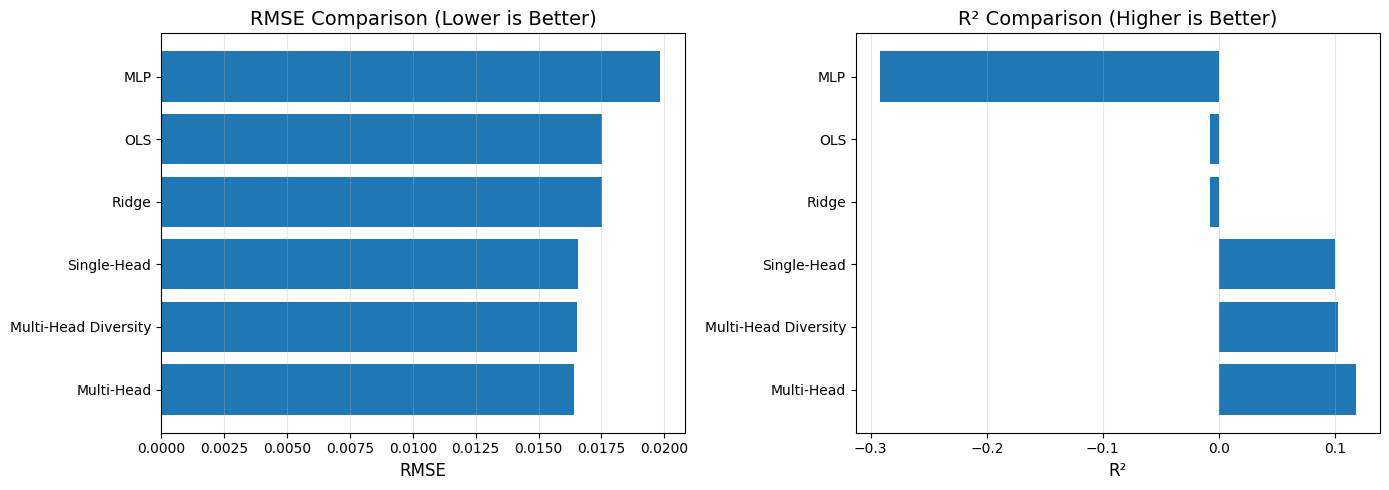

In [12]:
def make_predictions(model, X, device='cpu', batch_size=128, is_sklearn=False):
    """Make predictions with a model (deterministic mode)."""
    if is_sklearn:
        # sklearn models
        return model.predict(X)
    
    # PyTorch models
    model.eval()
    
    # Ensure deterministic mode - disable dropout
    with torch.no_grad():
        for module in model.modules():
            if isinstance(module, nn.Dropout):
                module.eval()
        
        predictions = []
        
        # Get num_features - handle both FeatureTokenTransformer and SingleHeadTransformer
        if hasattr(model, 'num_features'):
            num_features = model.num_features
        elif hasattr(model, 'model') and hasattr(model.model, 'num_features'):
            # SingleHeadTransformer wraps FeatureTokenTransformer in self.model
            num_features = model.model.num_features
        else:
            # Fallback: use input dimension
            num_features = X.shape[1]
        
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size]
            X_tensor = torch.FloatTensor(batch).to(device)
            
            # Handle padding if needed
            if X_tensor.shape[1] != num_features:
                if X_tensor.shape[1] < num_features:
                    padding = torch.zeros(X_tensor.shape[0], num_features - X_tensor.shape[1]).to(device)
                    X_tensor = torch.cat([X_tensor, padding], dim=1)
                else:
                    X_tensor = X_tensor[:, :num_features]
            
            pred = model(X_tensor)
            if isinstance(pred, tuple):
                pred = pred[0]
            predictions.append(pred.cpu().numpy())
    
    return np.concatenate(predictions, axis=0).flatten()

# Make predictions on validation set
print("Making predictions on validation set...")
predictions = {}

for name, model in models.items():
    is_sklearn = name in ['OLS', 'Ridge', 'XGBoost']
    pred = make_predictions(model, X_val_scaled, device, is_sklearn=is_sklearn)
    predictions[name] = pred.flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    r2 = r2_score(y_val, pred)
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²: {r2:.6f}")
    print()
comparison_data = []
for name in ['OLS', 'Ridge', 'XGBoost', 'MLP', 'Single-Head', 'Multi-Head', 'Multi-Head Diversity']:
    if name in training_history:
        comparison_data.append({
            'Model': name,
            'RMSE': training_history[name]['rmse'],
            'R²': training_history[name]['r2']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R²', ascending=False)

print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
ax1.barh(comparison_df['Model'], comparison_df['RMSE'])
ax1.set_xlabel('RMSE', fontsize=12)
ax1.set_title('RMSE Comparison (Lower is Better)', fontsize=14)
ax1.grid(True, alpha=0.3, axis='x')

# R² comparison
ax2.barh(comparison_df['Model'], comparison_df['R²'])
ax2.set_xlabel('R²', fontsize=12)
ax2.set_title('R² Comparison (Higher is Better)', fontsize=14)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 3. Adversarial Training (A1-A4 Attacks)

Train transformer models with adversarial training against A1-A4 attacks to improve robustness.